# Problem 4

A logistic regression classifier. Learn a logistic regression classifier over the training set
using the methods/notebook covered in class, and compare its performance on the test set.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('/content/sample_data/question4_train.csv')
test = pd.read_csv('/content/sample_data/question4_test.csv')

In [ ]:
# split into X (features) and y (target)
X_train = train[['f1', 'f2']]
y_train = train['class']

X_test  = test[['f1', 'f2']]
y_test  = test['class']

           Estimate
Intercept  0.468135
f1        -0.085705
f2         0.001323

Performance:

Accuracy: 0.617

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      0.53      0.61        34
     Class 1       0.54      0.73      0.62        26

    accuracy                           0.62        60
   macro avg       0.63      0.63      0.62        60
weighted avg       0.64      0.62      0.62        60

Confusion Matrix:
[[18 16]
 [ 7 19]]

ROC AUC: 0.683


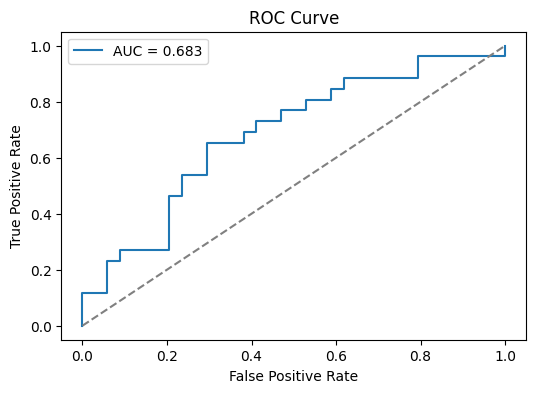

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

# get numeric values
intercept = clf.intercept_[0]
coef_f1, coef_f2 = clf.coef_[0]

# display coefficients
import pandas as pd
coef_df = pd.DataFrame({
    'Estimate': [intercept, coef_f1, coef_f2]
}, index=['Intercept', 'f1', 'f2'])

print(coef_df)
print()


# performance metrics
print("Performance:\n")
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0','Class 1']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {auc:.3f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

A 1-level decision tree

In [ ]:
results = []
# 2) Loop over both features and all thresholds
for feat in ['f1','f2']:
    for t in [2,4,6,8]:
        # Split the training set
        left  = train[train[feat] <= t]
        right = train[train[feat] >  t]
        # Skip degenerate leaves
        if len(left) < 5 or len(right) < 5:
            continue

        # 3) Fit a separate LR on each leaf
        clf_L = LogisticRegression().fit(left[['f1','f2']], left['class'])
        clf_R = LogisticRegression().fit(right[['f1','f2']], right['class'])

        # 4) Route test samples through the same split and predict
        y_pred = []
        for _, row in test.iterrows():
            X = [[row['f1'], row['f2']]]
            if row[feat] <= t:
                y_pred.append(clf_L.predict(X)[0])
            else:
                y_pred.append(clf_R.predict(X)[0])

        # 5) Evaluate
        acc = accuracy_score(y_test, y_pred)
        results.append({'feature': feat, 'threshold': t, 'accuracy': acc})

# 6) Collect & inspect
df = pd.DataFrame(results)
print(df.sort_values('accuracy', ascending=False).reset_index(drop=True))

best = df.loc[df['accuracy'].idxmax()]
print("\nBest split:", best.to_dict())

  feature  threshold  accuracy
0      f1          4  0.983333
1      f2          4  0.950000
2      f1          6  0.816667
3      f2          2  0.800000
4      f2          6  0.750000
5      f1          2  0.750000
6      f1          8  0.650000
7      f2          8  0.550000

Best split: {'feature': 'f1', 'threshold': 4, 'accuracy': 0.9833333333333333}


A 2-level decision tree

In [ ]:
features  = ['f1','f2']
thresholds = [2,4,6,8]

results = []
# 2) 穷举根节点的特征和阈值
for root_feat in features:
    for root_thr in thresholds:
        # 根节点分左右子集
        train_L = train[train[root_feat] <= root_thr]
        train_R = train[train[root_feat] >  root_thr]
        # 如果任一边样本不足，就跳过
        if len(train_L)<10 or len(train_R)<10:
            continue

        # 3) 穷举左子树和右子树的第二层分裂
        for left_feat in features:
            for left_thr in thresholds:
                for right_feat in features:
                    for right_thr in thresholds:
                        # 定义四个叶子训练集
                        leaf1 = train_L[train_L[left_feat] <= left_thr]
                        leaf2 = train_L[train_L[left_feat] >  left_thr]
                        leaf3 = train_R[train_R[right_feat] <= right_thr]
                        leaf4 = train_R[train_R[right_feat] >  right_thr]
                        # 任一叶子样本太少则跳过
                        if min(len(leaf1),len(leaf2),len(leaf3),len(leaf4)) < 5:
                            continue

                        # 在“4) 在每个叶子上训练”之前，插入：
                        if leaf1['class'].nunique() < 2 or leaf2['class'].nunique() < 2 or leaf3['class'].nunique() < 2 or leaf4['class'].nunique() < 2:
                            continue

                        # 4) 在每个叶子上训练独立 Logistic Regression
                        clf1 = LogisticRegression().fit(leaf1[['f1','f2']], leaf1['class'])
                        clf2 = LogisticRegression().fit(leaf2[['f1','f2']], leaf2['class'])
                        clf3 = LogisticRegression().fit(leaf3[['f1','f2']], leaf3['class'])
                        clf4 = LogisticRegression().fit(leaf4[['f1','f2']], leaf4['class'])

                        # 5) 对测试集逐样本“走树”预测
                        y_pred = []
                        for _, row in test.iterrows():
                            if row[root_feat] <= root_thr:
                                # 进入左子树
                                if row[left_feat] <= left_thr:
                                    y_pred.append(clf1.predict([[row['f1'],row['f2']]])[0])
                                else:
                                    y_pred.append(clf2.predict([[row['f1'],row['f2']]])[0])
                            else:
                                # 进入右子树
                                if row[right_feat] <= right_thr:
                                    y_pred.append(clf3.predict([[row['f1'],row['f2']]])[0])
                                else:
                                    y_pred.append(clf4.predict([[row['f1'],row['f2']]])[0])

                        # 6) 计算准确率并记录
                        acc = accuracy_score(y_test, y_pred)
                        results.append({
                            'root_feat':  root_feat,
                            'root_thr':   root_thr,
                            'left_feat':  left_feat,
                            'left_thr':   left_thr,
                            'right_feat': right_feat,
                            'right_thr':  right_thr,
                            'accuracy':   acc
                        })

# 7) find the best solotion
df = pd.DataFrame(results)
df = df.sort_values('accuracy', ascending=False).reset_index(drop=True)
print(df.head(20))        # 查看前几名
print("\nBest split:", df.loc[0].to_dict())

   root_feat  root_thr left_feat  left_thr right_feat  right_thr  accuracy
0         f1         4        f1         2         f2          4  0.983333
1         f1         4        f2         4         f2          8  0.983333
2         f1         4        f2         4         f2          4  0.983333
3         f1         4        f1         2         f2          8  0.983333
4         f2         4        f1         4         f1          4  0.983333
5         f2         4        f1         6         f1          4  0.983333
6         f2         4        f2         2         f1          4  0.983333
7         f2         4        f1         8         f1          4  0.983333
8         f1         8        f1         4         f2          4  0.983333
9         f1         4        f1         2         f2          2  0.966667
10        f1         4        f1         2         f1          6  0.966667
11        f1         4        f1         2         f1          8  0.966667
12        f2         2   

Based on the accuracy of 3 model on the test dataset, the both decsion tree have same highest accuracy that much higher than logistic regression.
The 1-level decision tree has N features and T threshold, so it has N*T candidates tree. The 2-level decision tree has N*T candidates subtree on each child node, so the number of total candidates tree is (N*T) * (N*T) * (N*T). Considering the computational cost, the 1-level decision tree is better than 2-level if their accuracy are relatively same. On this dataset, the 1-level decision tree would be preferable because it achieve a good balance between accuracy and computation cost.

# Problem 5

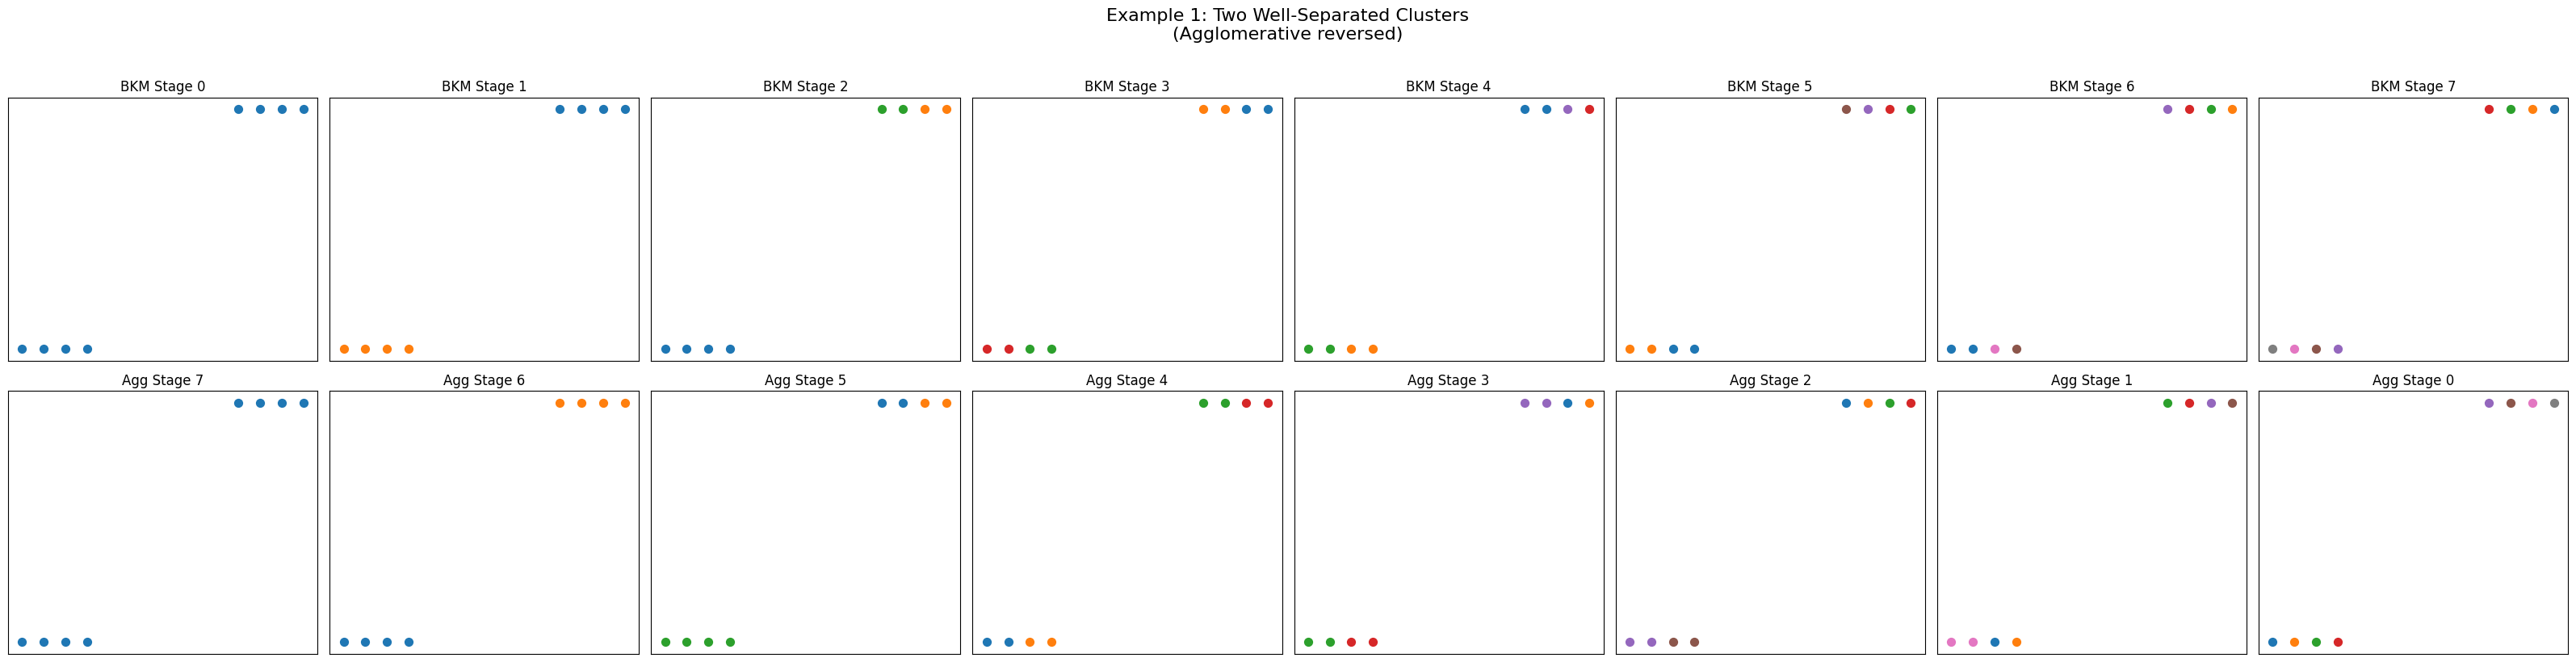

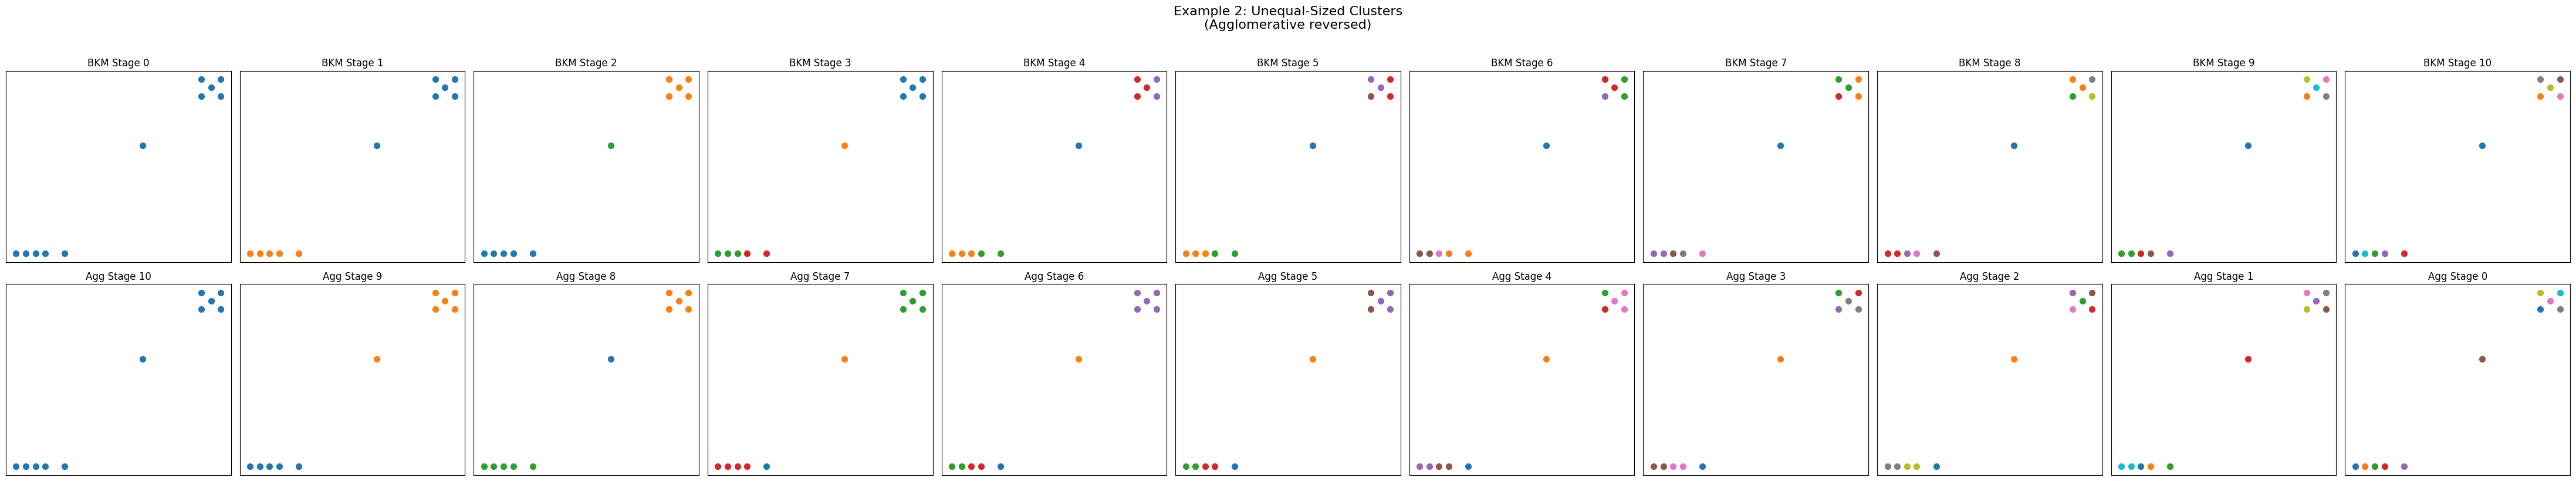

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def bisecting_kmeans(X, num_splits, random_state=0):
    """
    Bisecting k-means: repeatedly split the cluster with largest SSE into two using k-means (k=2).
    Returns history of clusters at each split stage.
    """
    clusters = [np.arange(len(X))]
    history = [[c.copy() for c in clusters]]
    for _ in range(num_splits):
        # 1) 计算每个簇的 SSE
        sses = []
        for idxs in clusters:
            pts = X[idxs]
            sses.append(0 if len(pts) <= 1 else ((pts - pts.mean(axis=0))**2).sum())
        # 2) 选出 SSE 最大的簇
        i = int(np.argmax(sses))
        to_split = clusters.pop(i)
        pts = X[to_split]
        # 3) 用 k=2 做 k-means 拆分
        km = KMeans(n_clusters=2, random_state=random_state, n_init=10).fit(pts)
        labels = km.labels_
        clusters.extend([to_split[labels==0], to_split[labels==1]])
        history.append([c.copy() for c in clusters])
    return history

def agglomerative_sse(X):
    """
    Agglomerative clustering: merge the pair of clusters whose union causes the smallest increase in SSE.
    Returns history of clusters at each merge stage.
    """
    clusters = [[i] for i in range(len(X))]
    history = [[c.copy() for c in clusters]]
    def sse(idxs):
        if len(idxs) <= 1:
            return 0
        pts = X[idxs]
        return ((pts - pts.mean(axis=0))**2).sum()

    # 反复合并直到只剩一个簇
    while len(clusters) > 1:
        best = (None, None, np.inf)
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                merged = clusters[i] + clusters[j]
                cost = sse(merged) - sse(clusters[i]) - sse(clusters[j])
                if cost < best[2]:
                    best = (i, j, cost)
        i, j, _ = best
        new = clusters[i] + clusters[j]
        clusters.pop(j)
        clusters.pop(i)
        clusters.append(new)
        history.append([c.copy() for c in clusters])
    return history

def plot_example(X, bisect_hist, agglo_hist, example_title):
    """
    Plot bisecting k-means (top row) and agglomerative reversed (bottom row).
    """
    # 倒序 Agglomerative 历史
    agglo_rev = list(reversed(agglo_hist))
    n_b = len(bisect_hist)
    n_a = len(agglo_rev)
    total = max(n_b, n_a)

    fig, axs = plt.subplots(2, total, figsize=(4*total, 8))

    # 上排：Bisecting k-means 顺序展示
    for t, clusters in enumerate(bisect_hist):
        ax = axs[0, t]
        for c in clusters:
            pts = X[np.array(c)]
            ax.scatter(pts[:,0], pts[:,1], s=50)
        ax.set_title(f"BKM Stage {t}")
        ax.set_xticks([]); ax.set_yticks([])
    for t in range(n_b, total):
        axs[0, t].axis('off')

    # 下排：Agglomerative 倒序展示
    for idx, clusters in enumerate(agglo_rev):
        ax = axs[1, idx]
        for c in clusters:
            pts = X[np.array(c)]
            ax.scatter(pts[:,0], pts[:,1], s=50)
        orig_stage = len(agglo_hist) - 1 - idx
        ax.set_title(f"Agg Stage {orig_stage}")
        ax.set_xticks([]); ax.set_yticks([])
    for t in range(n_a, total):
        axs[1, t].axis('off')

    fig.suptitle(example_title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def main():
    # Example 1: two well-separated clusters
    X1 = np.array([[0,0], [1,0],[2,0],[3,0], [10,10], [11,10], [12,10], [13,10]])
    bisect1 = bisecting_kmeans(X1, num_splits=len(X1)-1)
    agglo1  = agglomerative_sse(X1)
    plot_example(X1, bisect1, agglo1,
                 "Example 1: Two Well-Separated Clusters\n(Agglomerative reversed)")

    # Example 2: three clusters of different sizes (3,1,3)
    X2 = np.array([
        [0, 0], [1, 0], [2, 0], [3,0], [5,0],   # Cluster A (3 pts)
        [13, 13],               # Cluster B (1 pt)
        [20, 20], [21, 19], [19, 21], [21, 21], [19, 19] # Cluster C (3 pts)
    ])
    bisect2 = bisecting_kmeans(X2, num_splits=len(X2)-1)
    agglo2  = agglomerative_sse(X2)
    plot_example(X2, bisect2, agglo2,
                 "Example 2: Unequal-Sized Clusters\n(Agglomerative reversed)")

if __name__ == "__main__":
    main()



The example 1 clusters are well separated with same shape and cardinality.
The example 2 clusters are not well separated. The one point cluster is closer to the upper five pointes cluster. There is no differences between two classification in the first 3 stages, so the cluster separation doesn't drive the divergence. The upper and lower clusters have differednt cardinality and different shape. One is skewed and another one is symmetric. When model merges pairs in the two clusters, both clusters are divided into different dendrograms. The sysmetric cluster does not appeares as same dendrograms as expected. So cardinality drives Bisecting k-means to preferentially split larger clusters first, whereas Agglomerative clustering focuses on local pairwise distances, leading to fundamentally divergent dendrogram hierarchies.

# Problem 6

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('/content/sample_data/question6_weather_temperature.csv')
df = df.dropna(subset=['Next_Tmax']).dropna()

X = df.drop(columns=['Next_Tmax'])
y = df['Next_Tmax']


In [ ]:
# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Feature selection: keep top 10 predictive features
selector = SelectKBest(f_regression, k=10)
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs  = selector.transform(X_test)

selected = X.columns[selector.get_support()].tolist()
print("Selected features:", selected)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fs)
X_test_scaled  = scaler.transform(X_test_fs)

Selected features: ['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4']


I apply an analysis of variance, F-test, between each features and he target
y to compute an F-statistic, which measures the strength of the linear relationship between that feature and the target. I retain only the 10 features with the highest scores and discard the rest.

In [ ]:
# 3. Train three regression models and evaluate
models = {
    "LinearRegression":   LinearRegression(),
    "Ridge (α=1.0)":      Ridge(alpha=1.0),
    "RandomForest (100)": RandomForestRegressor(n_estimators=100, random_state=42),
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train_scaled, y_train)
    y_pred = mdl.predict(X_test_scaled)
    results[name] = {
        "MAE":  mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R²":   r2_score(y_test, y_pred)
    }

# 4. Display performance comparison
results_df = pd.DataFrame(results).T
print("\nTest set performance:")
print(results_df)



Test set performance:
                         MAE      RMSE        R²
LinearRegression    1.134556  1.491098  0.761618
Ridge (α=1.0)       1.134519  1.491086  0.761622
RandomForest (100)  0.793329  1.054707  0.880732


Nearly identical performance (MAE ≈1.13 °C, RMSE ≈1.49 °C,R2 ≈0.76), indicating that adding an L2 penalty with α=1 does not materially change the fit on this dataset. Reduces MAE from 1.13 to 0.79 and RMSE from 1.49 to 1.05, while boosting R2 from 0.76 to 0.88, which shows that capturing non linear effects and feature interactions is important for next day max temperature prediction. Linear models are simple and interpretable but miss complex non linear relationships, yielding higher errors. Random Forest effectively captures non‐linearities and interactions, significantly lowering error at the cost of reduced interpretability and higher computational cost.

# Problem 7

In [ ]:
! curl -L -o ./creditcardfraud.zip\
  https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  10.8M      0  0:00:06  0:00:06 --:--:-- 15.8M
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
import pandas as pd
df = pd.read_csv('creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    average_precision_score,
    roc_auc_score,
    confusion_matrix
)

def main():
    # 1. 读取数据
    df = pd.read_csv('creditcard.csv')
    X = df.drop('Class', axis=1)
    y = df['Class']

    # 2. 标准化 Time 和 Amount
    scaler = StandardScaler()
    X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

    # 3. 划分训练/测试集（80/20），并保持类别分布
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 计算样本不平衡比率：neg / pos，用于 XGBoost 的 scale_pos_weight
    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    scale_pos_weight = neg_count / pos_count
    print(f"negative/{pos_count} = {scale_pos_weight:.2f}")

    # 4. 定义三个分类器
    classifiers = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000, class_weight='balanced', random_state=42
        ),
        'SVM (RBF kernel)': SVC(
            kernel='rbf', probability=True,
            class_weight='balanced', random_state=42
        ),
        'XGBoost': XGBClassifier(
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight,
            random_state=42
        ),
    }

    # 5. train and evaluate
    for name, clf in classifiers.items():
        print(f"\n====== {name} ======")
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1]  # 取正类(1)概率

        # （1）Precision / Recall / F1
        print(classification_report(y_test, y_pred, digits=4))

        # （2）Average Precision & ROC AUC
        ap = average_precision_score(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"Average Precision (AP): {ap:.4f}")
        print(f"ROC AUC:               {roc_auc:.4f}")

        # （3）confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)

if __name__ == '__main__':
    main()

negative/394 = 577.29

====== Logistic Regression ======
              precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0609    0.9184    0.1141        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5509     56962
weighted avg     0.9982    0.9755    0.9861     56962

Average Precision (AP): 0.7189
ROC AUC:               0.9722
Confusion Matrix:
[[55475  1389]
 [    8    90]]

====== SVM (RBF kernel) ======
              precision    recall  f1-score   support

           0     0.9996    0.9969    0.9983     56864
           1     0.3047    0.7959    0.4407        98

    accuracy                         0.9965     56962
   macro avg     0.6522    0.8964    0.7195     56962
weighted avg     0.9985    0.9965    0.9973     56962

Average Precision (AP): 0.4525
ROC AUC:               0.9739
Confusion Matrix:
[[56686   178]
 [   20    78]]

====== XGBoost ======
              

I evaluated three standard supervised classifiers—Logistic Regression, an RBF kernel SVM, and XGBoost on an imbalanced credit-card fraud dataset. To focus on the rare fraud class, I reported its precision, recall and F1 score from the classification report, measured ROC AUC as the area under the ROC curve, and inspected the confusion matrix to see the raw counts of true positives, false positives, false negatives and true negatives. The precision and recall of fraud are approriate for for the anomaly detection task. Logistic Regression achieved extremely high recall but very low precision, indicating it classifies much transactions as normal. SVM achieves a better balance with precision and recall for fraud class. XGBoost delivered the strongest overall fraud class performance where precision is 88.2% and recall is 83.7%. XGBoost by fitting complex patterns, employing boosting, and incorporating class weighting， simultaneously keeps both false positives and false negatives very low, achieving the optimal precision and recall trade-off in highly imbalanced dataset.